In [10]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

from PhaseFunctionedNetwork import PhaseFunctionedNetwork
from train_utils import train_pfnn_thresh

# set seeds for reproduceability
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.RandomState(42)

# DATA AUG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
ROUND = 2
ROOT_PATH = 'C:/Users/Ana/Desktop/dev/pfnn-dev/Export/v10.0_data/'
INPUT_PATH = 'Input_'
OUTPUT_PATH = 'Output_'

def get_change_in_phase(phase_arr):
    change_in_phase =  phase_arr[1:] - phase_arr[:-1]
    change_in_phase[change_in_phase < 0] = (1.0 - phase_arr[:-1] + phase_arr[1:])[change_in_phase < 0]
    change_in_phase = np.append(change_in_phase, change_in_phase[-1]) #TODO IF BREAKS append 2pi
    return change_in_phase

def load_data(action_name):
    extension = ".txt"
    X_arr = np.float32(np.loadtxt(ROOT_PATH + INPUT_PATH + action_name + extension))
    Y_arr = np.float32(np.loadtxt(ROOT_PATH + OUTPUT_PATH + action_name + extension))
    
    return X_arr, Y_arr

def get_phase(X_arr):
    P_arr = np.round(np.linspace(0, 0.99, num=X_arr.shape[0]), ROUND)
    return P_arr

In [12]:
file_count = sum(1 for filename in os.listdir(ROOT_PATH) if filename.endswith('.txt'))

print(f"Processed {file_count} files")

X = []
Y = []
P = np.empty(0)
delta_phase = np.empty(0)

for i in range(int(file_count/2)):
    input_data, output_data = load_data(str(i))
    phase_data = get_phase(input_data)
    change_in_phase = get_change_in_phase(phase_data)

    X.append(input_data)
    Y.append(output_data)
    P = np.append(P, phase_data)
    delta_phase = np.append(delta_phase, change_in_phase)

# stack all the arrays on top of each other
X = np.vstack(X)
Y = np.vstack(Y)
delta_phase = delta_phase.flatten()
P = P.flatten()

# Y = np.concatenate([Y, delta_phase [..., np.newaxis]], axis=-1)
# print stats 
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"Phase data shape: {P.shape}")
print(f"Delta phase shape: {delta_phase.shape}")

Processed 70 files
Input data shape: (1858, 960)
Output data shape: (1858, 891)
Phase data shape: (1858,)
Delta phase shape: (1858,)


In [13]:
# ADD IDLE ANIMATION
ROOT_PATH = 'C:/Users/Ana/Desktop/dev/pfnn-dev/Export/v9.0_data/Stylev2/'
INPUT_PATH = 'Input_'
OUTPUT_PATH = 'Output_'

# Load Data
ROUND = 2

X_idle = np.float32(np.loadtxt(ROOT_PATH + INPUT_PATH + 'Idle_Static.txt'))
Y_idle = np.float32(np.loadtxt(ROOT_PATH + OUTPUT_PATH + 'Idle_Static.txt'))
P_idle = np.round(np.append(np.linspace(0, 0.99, num=36), np.linspace(0, 0.99, num=36)), ROUND)
delta_idle = get_change_in_phase(P_idle)

X = np.concatenate((X, X_idle))
Y = np.concatenate((Y, Y_idle))
delta_phase = np.concatenate((delta_phase, delta_idle))
P = np.concatenate((P, P_idle))

Y = np.concatenate([Y, delta_phase [..., np.newaxis]], axis=-1)
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"Phase data shape: {P.shape}")
print(f"Delta phase shape: {delta_phase.shape}")

Input data shape: (1930, 960)
Output data shape: (1930, 892)
Phase data shape: (1930,)
Delta phase shape: (1930,)


In [14]:
def preprocess_X(X_arr):
    Xmean, Xstd = X_arr.mean(axis=0), X_arr.std(axis=0)

    # lists to keep track of indices for TRAJECTORY
    X_traj_pos_indices = []
    X_traj_dir_indices = []
    X_traj_style_indices = []
    X_traj_slope_indices = []

    # number of eleements for each trajectory point
    w = 8
    for i in range(0, 95, w):
        X_traj_pos_indices = np.append(X_traj_pos_indices, range(i,i+3)).astype(int)
        X_traj_dir_indices = np.append(X_traj_dir_indices, range(i+3,i+5)).astype(int)
        X_traj_slope_indices = np.append(X_traj_slope_indices, i+5).astype(int)
        X_traj_style_indices = np.append(X_traj_style_indices, range(i+6,i+8)).astype(int)

    # lists to keep track of indices for JOINTS
    X_joint_pos_indices = []
    X_joint_vel_indices = []

    # num of elements for each joint
    w = 6
    for i in range(96, 959, w):
        X_joint_pos_indices = np.append(X_joint_pos_indices, range(i,i+3)).astype(int)
        X_joint_vel_indices = np.append(X_joint_vel_indices, range(i+3,i+6)).astype(int)

    # INPUT Trajectory data
    Xstd[X_traj_pos_indices] = Xstd[X_traj_pos_indices].mean()
    Xstd[X_traj_dir_indices] = Xstd[X_traj_dir_indices].mean()
    Xstd[X_traj_style_indices] = Xstd[X_traj_style_indices].mean()
    Xstd[X_traj_slope_indices] = Xstd[X_traj_slope_indices].mean()

    # INPUT Joint data --> This is where we weight the joints
    # Xstd[X_joint_pos_indices] = Xstd[X_joint_pos_indices].mean() / (joint_weights * 0.1)
    # Xstd[X_joint_vel_indices] = Xstd[X_joint_vel_indices].mean() / (joint_weights * 0.1)
    Xstd[X_joint_pos_indices] = Xstd[X_joint_pos_indices].mean() 
    Xstd[X_joint_vel_indices] = Xstd[X_joint_vel_indices].mean()

    return Xmean, Xstd

def preprocess_Y(Y_arr):
    Ymean, Ystd = Y_arr.mean(axis=0), Y_arr.std(axis=0)

    # PREPROCESS OUTPUT Y
    # lists to keep track of indices for TRAJECTORY
    Y_traj_pos_indices = []
    Y_traj_dir_indices = []

    # number of trajectory elements
    w = 4
    for i in range(0, 23, w): #TODO UPDATE THE RANGE
        Y_traj_pos_indices = np.append(Y_traj_pos_indices, range(i,i+2)).astype(int)
        Y_traj_dir_indices = np.append(Y_traj_dir_indices, range(i+2,i+4)).astype(int)

    # lists to keep track of indices for JOINTS
    Y_joint_pos_indices = []
    Y_joint_vel_indices = []

    # num of joint elements
    w = 6
    for i in range(24, 887, w): #TODO UPDATE THE RANGE
        Y_joint_pos_indices = np.append(Y_joint_pos_indices, range(i,i+3)).astype(int)
        Y_joint_vel_indices = np.append(Y_joint_vel_indices, range(i+3,i+6)).astype(int)

    # OUTPUT Trajectory data
    Ystd[Y_traj_pos_indices] = Ystd[Y_traj_pos_indices].mean()
    Ystd[Y_traj_dir_indices] = Ystd[Y_traj_dir_indices].mean()

    # OUTPUT Joint data --> This is where we weight the joints
    # Ystd[Y_joint_pos_indices] = Ystd[Y_joint_pos_indices].mean() / (joint_weights * 0.1)
    # Ystd[Y_joint_vel_indices] = Ystd[Y_joint_vel_indices].mean() / (joint_weights * 0.1)
    Ystd[Y_joint_pos_indices] = Ystd[Y_joint_pos_indices].mean()
    Ystd[Y_joint_vel_indices] = Ystd[Y_joint_vel_indices].mean()
    
    # translational_vel_mean = (Ystd[-4] + Ystd[-2])/2
    # Ystd[-4] = translational_vel_mean
    # Ystd[-2] = translational_vel_mean

    return Ymean, Ystd

In [15]:
# Preprocess Data
Xmean, Xstd = preprocess_X(X)
Ymean, Ystd = preprocess_Y(Y)

WEIGHTS_SAVE_PATH = 'C:/Users/Ana/Desktop/dev/pfnn-dev/unity-pfnn/Assets/Dev/Weights/test/'

for i in range(Xstd.size):
    if (Xstd[i]==0):
        Xstd[i]=1
for i in range(Ystd.size):
    if (Ystd[i]==0):
        Ystd[i]=1

# save means and stds
Xmean.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Xmean.bin')
Ymean.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Ymean.bin')
Xstd.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Xstd.bin')
Ystd.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Ystd.bin')

# normalize data NOTE ORIGINAL DID THIS AFTER SAVING THE MEANS AND STD AS DONE HERE
X = (X - Xmean) / Xstd
Y = (Y - Ymean) / Ystd

# load data for PyTorch training

# append phase as additional feature only for training NN
input = torch.tensor(np.concatenate([X, P [..., np.newaxis]], axis=-1))
target = torch.tensor(Y)

print(f"Input shape {input.shape}")
print(f"Target shape {target.shape}")

dataset = TensorDataset(input, target)

Input shape torch.Size([1930, 961])
Target shape torch.Size([1930, 892])


In [21]:
# Define PFNN
model = PhaseFunctionedNetwork(input_shape=input.shape[1], output_shape=target.shape[1], dropout=0.7)

# Determine device for training 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Training variables
BATCH_SIZE = 32
EPOCHS = 500
LR = 0.0001
OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=LR)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train
model, loss_history = train_pfnn_thresh(model, train_dataloader, optimizer=OPTIMIZER, num_epochs=EPOCHS, device=DEVICE, threshold=0.05)

# Save
model.precompute_and_save_weights()

100%|██████████| 61/61 [00:05<00:00, 10.96it/s]


Epoch [1/500], Loss: 1.1944562321702517
inf


100%|██████████| 61/61 [00:05<00:00, 11.32it/s]


Epoch [2/500], Loss: 0.39598882332094015
0.7984674088493116


100%|██████████| 61/61 [00:05<00:00, 11.31it/s]


Epoch [3/500], Loss: 0.2634223484882091
0.13256647483273104


100%|██████████| 61/61 [00:05<00:00, 11.32it/s]


Epoch [4/500], Loss: 0.2329356824444003
0.030486666043808813
Training stopped as loss did not improve by set threshold of 0.05.


In [22]:
np.save('v10.0_base_thresh_0.05', loss_history)

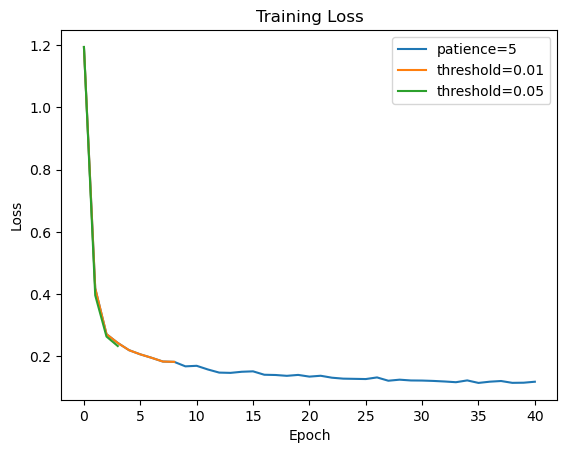

In [24]:
# # Plot
v9_base = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/v9.0_base_losshist.npy')
v10_base_patience = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/v10.0_base_patience5_losshist.npy')
v10_base_thresh1= np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/v10.0_base_thresh0.01_losshist.npy')
v10_base_thresh5= np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/v10.0_base_thresh0.05_losshist.npy')

# Create corresponding x values for each array
# x1 = np.arange(len(v9_base))
x2 = np.arange(len(v10_base_patience))
x3 = np.arange(len(v10_base_thresh1))
x4 = np.arange(len(v10_base_thresh5))

# Plot both arrays on the same plot
# plt.plot(x1, v9_base, label='Original')
plt.plot(x2, v10_base_patience, label='patience=5')
plt.plot(x3, v10_base_thresh1, label='threshold=0.01')
plt.plot(x4, v10_base_thresh5, label='threshold=0.05')

# Add title and labels
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Display the plot
plt.show()